# Zweifeldträger Schulbeispiel

Das Vorlesungsbeispiel verfolgt das Ziel, die Verformungen eines Zweifeldträgers für zwei Betonstähle mit unterschiedlichen Duktilitätsklassen aufzuzeigen. @jager_stahlbeton_2009.

![Statisches System des Zweifeldträgers mit Abmessungen versehen, daneben der Querschnitt mit Angaben zu der Längsbewehrung](../imgs/zweifeld_system.png){#fig-zweifeld_system}

Zunächst wird die analytische Lösung vollumfänglich dargestellt und mit numerischen Werten substituiert. Abschliessend wird das Verformungsverhalten mit dem Federmodell nachmodelliert, bzw. numerisch approximiert.

## Allgemeines

Vorgängig zu den Berechnungen werden die verwendeten Modelle kurz erläutert.

### Modellbildung - Zuggurtmodell

### Annahmen

- Zwei unterschiedliche Stähle
- konstant gerissene Biegesteifigkeit entlang der Stabachse

### Parameter



In [1]:
# | echo:false

from packages import *

In [2]:
# Längsbewehrung in X-Richtung gerichtet
diam_x = 14 * mm  
# Teilung der Längsbewehrung
s_x = 200 * mm  
# Längsbewehrung in Y-Richtung gerichtet
diam_y = 12 * mm
# Teilung der Längsbewehrung
s_y = 200 * mm  

put_out()

$$
\begin{aligned}
\oslash_{x} & = 14 \ \mathrm{mm} \quad & s_{x} & = 200 \ \mathrm{mm} \quad & \oslash_{y} & = 12 \ \mathrm{mm} \\ 
s_{y} & = 200 \ \mathrm{mm} \quad &  \quad &  
 \end{aligned}
$$

In [3]:
# Betonüberdeckung
c = 20 * mm  
# Plattenstärke
h = 300 * mm 
# Streifenbreite 
b_w = 1 * m
# Balkenlänge  
l = 8*m 
 # Statische Höhe in X-Richtung
d_x = h - c - diam_y - 1 / 2 * diam_x 

put_out()

$$
\begin{aligned}
c & = 20 \ \mathrm{mm} \quad & h & = 300 \ \mathrm{mm} \quad & b_{w} & = 1 \ \mathrm{m} \\ 
l & = 8 \ \mathrm{m} \quad & d_{x} & = 261.0 \ \mathrm{mm} \quad &  
 \end{aligned}
$$

## Kaltverformter Betonstahl - B500A

### Eigenschaften des Betonstahls

Allgemein werden die Eigenschaften für den Betonstahl B500A mit einem Suffix $A$ gekennzeichnet.


In [4]:
# Fliessgrenze
f_sy_A = 570 * N / mm**2  
# Zugfestigkeit
f_su_A = 600 * N / mm**2  
# Fliessdehnung
varepsilon_sy_A = 2.78*permille
# Bruchdehnung  
varepsilon_su_A = 25*permille  
# Elastizitätsmodul
E_s_A = 205 * kN / mm**2  
# Verfestigungsmodul
E_sh_A = 1350 * N / mm**2  

put_out()

$$
\begin{aligned}
f_{sy A} & = 570.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{su A} & = 600.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \varepsilon_{sy A} & = 2.78 \ \mathrm{‰} \\ 
\varepsilon_{su A} & = 25 \ \mathrm{‰} \quad & E_{s A} & = 205.0 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \quad & E_{sh A} & = 1350.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

In [5]:
# | echo: false

stress_b500a_array = np.array([0, f_sy.magnitude, f_su.magnitude]) * MPa
strain_b500a_array = np.array([0, varepsilon_sy, varepsilon_su])


fig, ax = plt.subplots()

ax.plot(strain_b500a_array, stress_b500a_array.to(MPa).magnitude, color="k")


# Set axis labels
ax.set_ylabel(r"$\sigma$ [N/mm$^2$]")
ax.set_xlabel(r"$\varepsilon_s$ [-]")

# Set limits
ax.set_xlim(xmax=125 / 1000)
ax.set_ylim(ymax=750)

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig("imgs/stress_strain_b500a.svg")
plt.close()

NameError: name 'f_sy' is not defined

![Spannungs-Dehnungs-Beziehung des Betonstahls B500A](../imgs/stress_strain_b500a.svg){#stress_strain_b500a}

### Eigenschaften des Betons

In [5]:
# Zylinderdruckfestigkeit vorausgesetzt
f_cc = 30 * N / mm**2

# Betonzugfestigkeit, nicht einheitentreu
f_ct = (0.3 * f_cc.magnitude ** (2 / 3)) * N / mm**2 

# Effektive Betondruckfestigkeit, nicht einheitentreu
f_c = (2.5 * f_cc.magnitude ** (2 / 3)) * N / mm**2 

# Elastizitätsmodul des Betons
E_c = 29.3*kN/mm**2

# Bruchstauchung Erfahrungswert
varepsilon_cu = 5 *permille

put_out()

$$
\begin{aligned}
f_{cc} & = 30.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{ct} & = 2.9 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{c} & = 24.14 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
E_{c} & = 29.3 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \quad & \varepsilon_{cu} & = 5 \ \mathrm{‰} \quad &  
 \end{aligned}
$$

### Linear elastische - gerissene Biegesteifigkeit

Querschnittsanalyse:


In [6]:
# Querschnittsfläche der Längsbewehrung, pro Längeneinheit
a_s = (diam_x**2 / 4 * np.pi / s_x).to(mm**2 / m)

# Wertigkeit der Elastizitätsmodule
n = E_s / E_c

put_out()

$$
\begin{aligned}
a_{s} & = 769.69 \ \frac{\mathrm{mm}^{2}}{\mathrm{m}} \quad & n & = 7.0 \  \end{aligned}
$$

Die Druckzonenhöhe wird mittels dem Gleichgewicht der horizontalen Kräfte ermittelt

In [7]:
# Mittels Sympy (CAS für Python) wird eine analytische Lösung der
# Druckzonenhöhe für den gerissenen Querschnitt ermittelt.

# Summe der horizontalen Kräfte
sum_Fx = sp.sympify("1/2*x*b_w*sigma_c -sigma_s*a_s*b_w")

# Definition der Spannung in Abhängigkeit der Dehnungen
expr_sigma_c = sp.sympify("varepsilon_c * E_c")
expr_sigma_s = sp.sympify("varepsilon_s * n * E_c")

# Die Beziehung zwischen der Stahl- und Betondehnung nach Hook
expr_epsilon_c = sp.sympify("varepsilon_s /(d-x)*x")

# Substitution der Gleichungen
sum_Fx_subs = sum_Fx.subs(
    {
        "sigma_c": expr_sigma_c.subs("varepsilon_c", expr_epsilon_c),
        "sigma_s": expr_sigma_s,
    }
)

# Erstellen einer numerischen Funktion
x_solve = sp.solve(sum_Fx_subs, "x")[1]
x_solve_lambd = sp.lambdify(("a_s", "b_w", "n", "d"), x_solve)

In [8]:
# Druckzonenhöhe mit Parametern substituiert
x_II = x_solve_lambd(a_s, b_w, n, d_x).to(mm)

# Flächenmoment 2. Grades für den gerissenen Querschnitt
I_cII = (b_w * x_II**3 / 12 + b_w * x_II * (x_II / 2) ** 2).to(mm**4)
I_sII = (a_s * b_w * n * (d_x - x_II) ** 2).to(mm**4)
I_II = (I_cII + I_sII).to(mm**4)

# Gerissene Biegesteifigkeit
EI_II = (E_c * I_II).to(kN * m**2)

put_out()

$$
\begin{aligned}
x_{II} & = 47.91 \ \mathrm{mm} \quad & I_{cII} & = 36650532.72 \ \mathrm{mm}^{4} \quad & I_{sII} & = 244534349.46 \ \mathrm{mm}^{4} \\ 
I_{II} & = 281184882.18 \ \mathrm{mm}^{4} \quad & EI_{II} & = 8238.72 \ \mathrm{kN} \cdot \mathrm{m}^{2} \quad &  
 \end{aligned}
$$

Damit ist die Biegesteifigkeit definiert.

### Hebelarm der inneren Kräfte

Der Hebelarm der inneren Kräfte wird für den gesamten Träger als konstant angenommen.
Dabei wird dem Beton die Zylinderdruckfestigkeit hinterlegt, sowie erreich der Stahl die Zugfestigkeit.

In [9]:
# Druckzonenhöhe für den Zustand
x_dv = (a_s * b_w * f_su / (0.85 * f_cc * b_w)).to(mm)  

# Hebelarm der inneren Kräfte für diesen Zustand
d_v = d_x - 1 / 2 * 0.85 * x_dv  

# Biegewiderstand für diesen Zustand
m_us = (a_s * f_su * d_v).to(kN)

put_out()

$$
\begin{aligned}
x_{dv} & = 18.11 \ \mathrm{mm} \quad & d_{v} & = 253.3 \ \mathrm{mm} \quad & m_{us} & = 116.98 \ \mathrm{kN} \end{aligned}
$$

### Rissabstand

Frage an Hda, was hier gerechnet wird

In [10]:
# Abschätzung der mitwirkenden Höhe der Betonzugzone
h_eff = 2 * (h - d_x)  

# Geometrischer Bewehrungsgehalt
rho = (a_s / h_eff).to(percent)  

# maximaler Rissabstand
s_r0 = (diam_x * (1 - rho)  / (4 * rho)).to(mm)  

# minimaler Rissabstand
s_rl = 1/2 * s_r0 

# Annahme des Rissabstandes, entspricht dem Abstand der Querstäbe
s_r = 200 * mm  

put_out()

$$
\begin{aligned}
h_{eff} & = 78.0 \ \mathrm{mm} \quad & \rho & = 0.99 \ \mathrm{\%} \quad & s_{r0} & = 351.19 \ \mathrm{mm} \\ 
s_{rl} & = 175.59 \ \mathrm{mm} \quad & s_{r} & = 200 \ \mathrm{mm} \quad &  
 \end{aligned}
$$

### Risselement bei Fliessbeginn 

In [11]:
# Verbundschubspannung vor dem Fliessen
tau_b0 = 2 * f_ct

# minimale Stahlspannung
sigma_sy_3 = f_sy - 4 * tau_b0 * s_r / 2 / diam_x

# mittlere Stahldehnung
varepsilon_smy = ((sigma_sy_3 + f_sy) / (E_s * 2)).to(permille)

# Fliessmoment
m_y = (a_s * f_sy * d_v).to(kN*m/m)

put_out()

$$
\begin{aligned}
\tau_{b0} & = 5.79 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \sigma_{sy 3} & = 404.49 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \varepsilon_{smy} & = 2.38 \ \mathrm{‰} \\ 
m_{y} & = 111.13 \ \mathrm{kN} \quad &  \quad &  
 \end{aligned}
$$

### Risselement beim Erreichen der Zugfestigkeit

In [12]:
# Verbundschubspannung vor dem Fliessen
tau_b1 = f_ct

# Plastischer Bereich
Delta_x_pl = (f_su - f_sy) / (4*tau_b1 / diam_x)

# Elastischer Bereich
Delta_x_el = s_r /2 - Delta_x_pl

# minimale Stahlspannung
sigma_su_3 = f_sy - 4 * tau_b0 * Delta_x_el  / diam_x

put_out()

$$
\begin{aligned}
\tau_{b1} & = 2.9 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \Delta_{x pl} & = 36.25 \ \mathrm{mm} \quad & \Delta_{x el} & = 63.75 \ \mathrm{mm} \\ 
\sigma_{su 3} & = 464.49 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad &  \quad &  
 \end{aligned}
$$

In [13]:
# mittlere Stahldehnung
varepsilon_s_1 = varepsilon_su
varepsilon_s_2 = varepsilon_sy
varepsilon_s_3 = (sigma_su_3 / E_s).to(permille)

def center_trapez(a, b, b_1):
    return (b**2 + a**2 + a*b+2*a*b_1 + b*b_1) /(3*(a+b))

def area_trapez(a, b, h):
    return 1 / 2 * (a + b) * h

# Schwerpunkte der beiden Trapeze
S_1 = center_trapez(varepsilon_s_2, varepsilon_s_1, 0)
S_2 = center_trapez(varepsilon_s_3, varepsilon_s_2, 0)

# Flächen der beiden Trapeze
A_1 = area_trapez(varepsilon_s_1, varepsilon_s_2, Delta_x_pl)
A_2 = area_trapez(varepsilon_s_3, varepsilon_s_2, Delta_x_el)

varepsilon_sm = ((S_1 * A_1 + S_2 * A_2) / (A_1 + A_2))

put_out()

$$
\begin{aligned}
\varepsilon_{s 1} & = 25 \ \mathrm{‰} \quad & \varepsilon_{s 2} & = 2.78 \ \mathrm{‰} \quad & \varepsilon_{s 3} & = 2.27 \ \mathrm{‰} \\ 
S_{1} & = 8.43 \ \mathrm{‰} \quad & S_{2} & = 1.27 \ \mathrm{‰} \quad & A_{1} & = 503.53 \ \mathrm{mm} \cdot \mathrm{‰} \\ 
A_{2} & = 160.83 \ \mathrm{mm} \cdot \mathrm{‰} \quad & \varepsilon_{sm} & = 6.69 \ \mathrm{‰} \quad &  
 \end{aligned}
$$

In [14]:
Delta_x_el

<Quantity(63.7489541, 'millimeter')>

### Plastische Rotationswinkel


In [15]:
# Annahme für die Länge des plastischen Gelenks
l_pl = 2 * d_x 

# Plastischer Rotationswinkel, Rotationsbedarf für vollständige Umlagerung.
Theta_pl = (l_pl * (varepsilon_sm - varepsilon_smy) / (d_x - x_dv)).to(deg)

put_out()

$$
\begin{aligned}
l_{pl} & = 522.0 \ \mathrm{mm} \quad & \Theta_{pl} & = 0.53 \ \mathrm{°} \end{aligned}
$$

### Fliessen des Mittelauflagers

In [16]:
# Die Streckenlast zum Erreichen des Fliessens bei B
q_y_comma_B = 8 * m_y * b_w / l**2

# maximale Verformung im Feld
w_m_y = (5*q_y_comma_B*l**4/(384*EI_II) - m_y*b_w * l**2 / (16*EI_II)).to(mm)

put_out()

$$
\begin{aligned}
q_{y , B} & = 13.89 \ \frac{\mathrm{kN}}{\mathrm{m}} \quad & w_{m y} & = 35.97 \ \mathrm{mm} \end{aligned}
$$

### Fliessbeginn im Feld

In [17]:
# Streckenlast beim Fliessbeginn im Feld
q_y_comma_F = ((4 * m_y + 2 * m_us)/ l**2 + 4/l**2 * np.sqrt(m_y**2 + m_y *m_us))*b_w

put_out()

$$
\begin{aligned}
q_{y , F} & = 20.55 \ \frac{\mathrm{kN}}{\mathrm{m}} \end{aligned}
$$

#### Rotationsvermögen

In [18]:
# Rotationswinkel (Verwendung der Arbeitsgleichung)
alpha = ((q_y_comma_F - q_y_comma_B)* l**3 / (24*EI_II) - (m_us - m_y)*b_w*l/(3*EI_II)).to(deg)

# Verformungsbedarf
Theta_erf = 2 * alpha

#Verformungsvermögen
Theta_pl

put_out()

$$
\begin{aligned}
\alpha & = 0.88 \ \mathrm{°} \quad & \Theta_{erf} & = 1.76 \ \mathrm{°} \quad & \Theta_{pl} & = 0.53 \ \mathrm{°} \end{aligned}
$$

Das Verformungsvermögen ist nicht ausreichend.

In [19]:
# maximaler Rotationswinkel
alpha_max = Theta_pl / 2

# Streckenlast bis zum maximalen Rotationswinkel
Delta_qu = ((alpha_max + (m_us - m_y)*l*b_w / (3*EI_II))*24*EI_II/l**3).to(kN/m)

# Traglast für B500A
q_u_B500A = Delta_qu + q_y_comma_B

put_out()

$$
\begin{aligned}
\alpha_{max} & = 0.27 \ \mathrm{°} \quad & \Delta_{qu} & = 2.52 \ \frac{\mathrm{kN}}{\mathrm{m}} \quad & q_{u B500A} & = 16.41 \ \frac{\mathrm{kN}}{\mathrm{m}} \end{aligned}
$$

In [20]:
# maximale Verformung im Feld
w_m_u = (5*q_u_B500A*l**4/(384*EI_II) - m_us*b_w * l**2 / (16*EI_II)).to(mm)

put_out()

$$
\begin{aligned}
w_{m u} & = 49.46 \ \mathrm{mm} \end{aligned}
$$

## Naturharter Stahl B500C

### Eigenschaften des Betonstahls

In [21]:
f_sy_A = 500 * N / mm**2  # Fliessgrenze
f_su_A = 600 * N / mm**2  # Zugfestigkeit
varepsilon_sy = 2.439*permille  # Fliessdehnung
varepsilon_sh = 20*permille # Dehnung bei Verfestigungsbeginn
varepsilon_su = 125*permille  # Bruchdehnung
E_s = 205 * kN / mm**2  # Elastizitätsmodul
E_sh = 952 * N / mm**2  # Verfestigungsmodul

put_out()

$$
\begin{aligned}
f_{sy} & = 500.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & f_{su} & = 600.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \varepsilon_{sy} & = 2.44 \ \mathrm{‰} \\ 
\varepsilon_{sh} & = 20 \ \mathrm{‰} \quad & \varepsilon_{su} & = 125 \ \mathrm{‰} \quad & E_{s} & = 205.0 \ \frac{\mathrm{kN}}{\mathrm{mm}^{2}} \\ 
E_{sh} & = 952.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad &  \quad &  
 \end{aligned}
$$

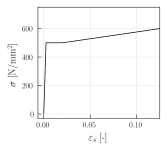

In [22]:
# | echo: false

stress_b500c_array = np.array([0, f_sy_A.magnitude, f_sy_A.magnitude, f_su_A.magnitude]) * MPa
strain_b500c_array = np.array([0, varepsilon_sy, varepsilon_sh, varepsilon_su])


fig_b500c, ax_b500c = plt.subplots()

ax_b500c.plot(strain_b500c_array, stress_b500c_array.to(MPa).magnitude, color="k")


# Set axis labels
ax_b500c.set_ylabel(r"$\sigma$ [N/mm$^2$]")
ax_b500c.set_xlabel(r"$\varepsilon_s$ [-]")

# Set limits
ax_b500c.set_xlim(xmax=125 / 1000)
ax_b500c.set_ylim(ymax=750)

# Show the plot
plt.tight_layout()
plt.savefig("imgs/stress_strain_b500c.svg")


![Spannungs-Dehnungs-Beziehung des Betonstahls B500C](../imgs/stress_strain_b500c.svg){#stress_strain_b500c}

### Vor dem Fliessen

In [23]:
# Mittlere Stahldehnung beim Fliessen
varepsilon_sm_y = varepsilon_sy - tau_b0 * s_r / (diam_x * E_s)

# Fliessmoment
m_y = (a_s * f_sy_A * d_v).to(kN)
put_out()

$$
\begin{aligned}
\varepsilon_{sm y} & = 2.04 \ \mathrm{‰} \quad & m_{y} & = 97.48 \ \mathrm{kN} \end{aligned}
$$

### Versagensart des Querschnitts

In [24]:
# Stahlspannung zwischen den Rissen
sigma_su_3 = f_su_A - 4 * tau_b1 / diam_x*s_r /2  

# Stahldehnung zwischen den Rissen
varepsilon_su_3 = ((sigma_su_3- f_sy_A) / E_sh + varepsilon_sh).to(permille)
varepsilon_sm = (varepsilon_su_3 + varepsilon_su)/2

put_out()

$$
\begin{aligned}
\sigma_{su 3} & = 517.24 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \varepsilon_{su 3} & = 38.11 \ \mathrm{‰} \quad & \varepsilon_{sm} & = 81.56 \ \mathrm{‰} \end{aligned}
$$

In [25]:
# Betonstauchung 
varepsilon_c =  varepsilon_sm / (d_x - x_dv) * x_dv

varepsilon_cu

put_out()

$$
\begin{aligned}
\varepsilon_{c} & = 6.08 \ \mathrm{‰} \quad & \varepsilon_{cu} & = 5 \ \mathrm{‰} \end{aligned}
$$

Die Betonbruchstauchung wird überschritten. Das bedeutet, es stellt sich ein Betondruckversagen vor einem Zerreissen der Bewehrung ein.

In [26]:
# Mittlere Stahldehnung beim Druckversagen
varepsilon_sm_u = varepsilon_cu / x_dv * (d_x - x_dv)

# Maximale Stahldehnung beim Druckversagen
varepsilon_smax_u = varepsilon_su - (varepsilon_sm-varepsilon_sm_u)

# Maximale Stahlspannung beim Druckversagen
sigma_smax_u = f_su_A - (varepsilon_su - varepsilon_smax_u)*E_sh

# Maximaler Biegewiderstand
m_u = (a_s * sigma_smax_u * d_v).to(kN*m/m)
put_out()

$$
\begin{aligned}
\varepsilon_{sm u} & = 67.06 \ \mathrm{‰} \quad & \varepsilon_{smax u} & = 110.5 \ \mathrm{‰} \quad & \sigma_{smax u} & = 586.2 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
m_{u} & = 114.29 \ \mathrm{kN} \quad &  \quad &  
 \end{aligned}
$$

### Verformungsvermögen

In [27]:
# Plastischer Rotationswinkel, Rotationsbedarf für vollständige Umlagerung.
Theta_pl_max = (l_pl * (varepsilon_sm_u - varepsilon_sm_y) / (d_x - x_dv)).to(deg)

put_out()

$$
\begin{aligned}
\Theta_{pl max} & = 8.01 \ \mathrm{°} \end{aligned}
$$

### Fliessen beim Mittelauflager

In [28]:
# Streckenlast beim Fliessen des Mittelauflagers
q_y_comma_B = 8 * m_y/l**2*b_w

# Verformung beim Fliessen des Mittelauflagers
w_m_y = (5*q_y_comma_B*l**4/(384*EI_II) - m_y*b_w * l**2 /(16 * EI_II)).to(mm)

put_out()

$$
\begin{aligned}
q_{y , B} & = 12.19 \ \frac{\mathrm{kN}}{\mathrm{m}} \quad & w_{m y} & = 31.55 \ \mathrm{mm} \end{aligned}
$$

### Fliessbeginn im Feld

#### Risselement beim Fliessen im Feld

In [29]:
# Im Feld wird das Fliessmoment erreicht
m_F = m_y

put_out()

$$
\begin{aligned}
m_{F} & = 97.48 \ \mathrm{kN} \end{aligned}
$$

In [30]:
# Fliessspannung wird vorausgesetzt

Delta_x_pl = 28.5*mm
Delta_x_el = s_r/2 - Delta_x_pl


sigma_s_2 = 500 *N/mm**2
sigma_s_1 = sigma_s_2 + 4 * tau_b1 / diam_x * Delta_x_pl
sigma_s_3 = sigma_s_2 - 4 * tau_b0 / diam_x * Delta_x_el

put_out()



$$
\begin{aligned}
\Delta_{x pl} & = 28.5 \ \mathrm{mm} \quad & \Delta_{x el} & = 71.5 \ \mathrm{mm} \quad & \sigma_{s 2} & = 500.0 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \\ 
\sigma_{s 1} & = 523.59 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & \sigma_{s 3} & = 381.66 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad &  
 \end{aligned}
$$

In [31]:
S_1 = center_trapez(sigma_s_2, sigma_s_1, 0*MPa)
S_2 = center_trapez(sigma_s_3, sigma_s_2, 0*MPa)

A_1 = area_trapez(sigma_s_1, sigma_s_2, Delta_x_pl)
A_2 = area_trapez(sigma_s_2, sigma_s_3, Delta_x_el)



In [32]:


sigma_sm = (A_1 * S_1 + A_2 * S_2) / (A_1 + A_2)


put_out()

$$
\begin{aligned}
\sigma_{sm} & = 232.56 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \end{aligned}
$$

In [33]:
# Dehnungen

varepsilon_s_1 = ((sigma_s_1 - sigma_s_2) / E_sh + varepsilon_sh).to(permille)
varepsilon_s_21 = varepsilon_sh
varepsilon_s_22 = varepsilon_sy
varepsilon_s_3 = (sigma_s_3 / E_s).to(permille)

S_1 = center_trapez(varepsilon_s_21, varepsilon_s_1, 0)
S_2 = center_trapez(varepsilon_s_3, varepsilon_s_22, 0)

A_1 = area_trapez(varepsilon_s_1, varepsilon_s_21, Delta_x_pl)
A_2 = area_trapez(varepsilon_s_22, varepsilon_s_3, Delta_x_el)

varepsilon_sm = (A_1 * S_1 + A_2 * S_2) / (A_1 + A_2)

put_out()

$$
\begin{aligned}
\varepsilon_{s 1} & = 44.77 \ \mathrm{‰} \quad & \varepsilon_{s 21} & = 20 \ \mathrm{‰} \quad & \varepsilon_{s 22} & = 2.44 \ \mathrm{‰} \\ 
\varepsilon_{s 3} & = 1.86 \ \mathrm{‰} \quad & S_{1} & = 16.98 \ \mathrm{‰} \quad & S_{2} & = 1.08 \ \mathrm{‰} \\ 
A_{1} & = 923.04 \ \mathrm{mm} \cdot \mathrm{‰} \quad & A_{2} & = 153.75 \ \mathrm{mm} \cdot \mathrm{‰} \quad & \varepsilon_{sm} & = 14.71 \ \mathrm{‰} \end{aligned}
$$

In [34]:
Theta_pl_q_y_comma_F = (l_pl * (varepsilon_sm - varepsilon_sm_y) / (d_x - x_dv)).to(deg)

put_out()

$$
\begin{aligned}
\Theta_{pl q y , F} & = 1.56 \ \mathrm{°} \end{aligned}
$$

In [35]:
# | echo:false

ax_b500c.axvline(x=varepsilon_s_1.to(los), color="black", linestyle="--")
ax_b500c.axhline(y=sigma_s_1.magnitude, color="black", linestyle="--")

# Show the updated plot
plt.tight_layout()
plt.figure(fig_b500c)
plt.savefig("imgs/stress_strain_b500c_with_vertical_line.svg")
plt.close()

![Spannungs-Dehnungs-Verlauf des Betonstahls B500C mit markierter maximaler Dehnung](../imgs/stress_strain_b500c_with_vertical_line.svg){#fig-stress_strain_b500c_marked}

In [36]:
# Stahlspannung durch maximale Stahldehnung am Zugglied
sigma_smax = np.interp(x = varepsilon_s_1.to(los), fp= stress_b500c_array.magnitude, xp= strain_b500c_array)*N/mm**2

# Biegemoment resultiert daraus zu
m_B = (a_s * sigma_smax * d_v).to(kN)

# Streckenlast Fliessen im Feld, verfestigend über dem Auflager
q_y_comma_F = ((4 * m_F + 2 * m_B)/l**2 + 4/l**2 * np.sqrt(m_F**2 + m_F * m_B))*b_w
put_out()

$$
\begin{aligned}
\sigma_{smax} & = 523.59 \ \frac{\mathrm{N}}{\mathrm{mm}^{2}} \quad & m_{B} & = 102.08 \ \mathrm{kN} \quad & q_{y , F} & = 18.0 \ \frac{\mathrm{kN}}{\mathrm{m}} \end{aligned}
$$

In [37]:
# Kontrolle des Verformungsbedarfs
alpha = ((q_y_comma_F - q_y_comma_B)*l**3 / (24*EI_II) - (m_B-m_y)*b_w*l / (3*EI_II)).to(deg)

# Erforderliche Rotation
Theta_pl_erf_i = 2 * alpha

# Kontrolle ob das Verformungsvermögen gleich dem Verformungsbedarf ist
Delta_Theta = Theta_pl_erf_i - Theta_pl_q_y_comma_F

put_out()

$$
\begin{aligned}
\alpha & = 0.78 \ \mathrm{°} \quad & \Theta_{pl erf i} & = 1.55 \ \mathrm{°} \quad & \Delta_{\Theta} & = -0.01 \ \mathrm{°} \end{aligned}
$$

In [38]:
# Die Mittendurchbiegung beträgt
w_m_y = (5*q_y_comma_F*l**4/(384*EI_II) - m_B*b_w * l**2 /(16 * EI_II)).to(mm)

put_out()

$$
\begin{aligned}
w_{m y} & = 66.96 \ \mathrm{mm} \end{aligned}
$$

### Traglast 

In [39]:
varepsilon_s_2 = varepsilon_sh 
varepsilon_s_1 = varepsilon_s_2 + 4 * tau_b1 * s_r/2  /(diam_x * E_sh)

varepsilon_sm_u = (varepsilon_s_2 + varepsilon_s_1)/2
put_out()

$$
\begin{aligned}
\varepsilon_{s 2} & = 20 \ \mathrm{‰} \quad & \varepsilon_{s 1} & = 106.93 \ \mathrm{‰} \quad & \varepsilon_{sm u} & = 63.46 \ \mathrm{‰} \end{aligned}
$$

In [40]:
sigma_s_max = np.interp(varepsilon_s_1, strain_b500c_array, stress_b500c_array)

m_B = m_u
m_F = (a_s * sigma_s_max * d_v).to(kN)

# Streckenlast Fliessen im Feld, verfestigend über dem Auflager
q_u_comma_F = ((4 * m_F + 2 * m_B)/l**2 + 4/l**2 * np.sqrt(m_F**2 + m_F * m_B))*b_w


# Plastische rotation im Feld
Theta_plf_F = (l_pl * (varepsilon_sm_u - varepsilon_sm_y) / (d_x - x_dv)).to(deg)


# Kontrolle des Verformungsbedarfs
alpha = (q_u_comma_F*l**3 / (24*EI_II) - (m_B)*b_w*l / (3*EI_II)+0.414*Theta_plf_F).to(deg)

# Erforderliche Rotation
Theta_pl_erf = 2 * alpha

# Kontrolle ob das Verformungsvermögen gleich dem Verformungsbedarf ist
Delta_Theta = Theta_pl_erf - Theta_pl_max

put_out()

$$
\begin{aligned}
\sigma_{s max} & = 582.79 \ \mathrm{MPa} \quad & m_{B} & = 114.29 \ \mathrm{kN} \quad & m_{F} & = 113.62 \ \mathrm{kN} \\ 
q_{u , F} & = 20.73 \ \frac{\mathrm{kN}}{\mathrm{m}} \quad & \Theta_{plf F} & = 7.56 \ \mathrm{°} \quad & \alpha & = 4.09 \ \mathrm{°} \\ 
\Theta_{pl erf} & = 8.18 \ \mathrm{°} \quad & \Delta_{\Theta} & = 0.17 \ \mathrm{°} \quad &  
 \end{aligned}
$$

In [41]:
# Die Mittendurchbiegung beträgt
w_m_y = (5*q_u_comma_F*l**4/(384*EI_II) - m_B*b_w * l**2 /(16 * EI_II) + 0.414*Theta_plf_F*l/2).to(mm)

put_out()

$$
\begin{aligned}
w_{m y} & = 297.33 \ \mathrm{mm} \end{aligned}
$$